### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 16
blocklen = (blocklenk * 1024)
# may need to adjust this depending on block length
blockcut = 512

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 2,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
# (I haven't used cxadc data in this dev cycle, so the parameters are probably wrong!)
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

In [6]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 2
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5
freq 40.0
dtype <class 'numpy.int16'>


In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=2.2 RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # post-demodulation deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(1, 0.5/freq_half, 'low')) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fcburst'] = filtfft(sps.butter(1, [(SP['fsc_mhz'] * .95)/freq_half, (SP['fsc_mhz'] * 1.05)/freq_half], btype='bandpass')) 
    else:
        SP['Fcburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fcburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [28]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real
    
    return np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    #return out_video, out_video05, out_videoburst

In [29]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [30]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [31]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [96]:
def demod(infile, _start, _end, filterset):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = _end
    
    if (_start > blockcut):
        start = _start - blockcut
    else:
        start = 0 # should this be an error?  prolly.

    print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(0, end - start, blocklen - blockcut):
        infile.seek(i * sampletype, 0)
        inbuf = infile.read(blocklen * sampletype)
        
        if sampletype == 2:
            indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
        else:
            indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
        if len(indata) < blocklen:
            print('b', len(indata), blocklen)
            break
    
        tmp = dodemod(filterset, indata, usemtf=True)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        #return dodemod(filterset, indata, usemtf=True)
        
        output_slice = slice(i, i + (blocklen - blockcut))
        if i + (blocklen - blockcut) < len(output):
            tmp_slice = slice(blockcut, len(tmp))
        else:
            tmp_slice = slice(blockcut, blockcut+len(output)-i)

        print(i, output_slice, tmp_slice)            
            
        output[output_slice] = tmp[tmp_slice]

    return output

In [97]:
if True: # DD 2.2/330pF and later
    params['freq'] = 40.0
    deemp_adj = .7
    params['deemp'] = (120*deemp_adj, 320*deemp_adj)
    sampletype = 2
else: # cxadc capture
    params['freq'] = 8 * 315 / 88
    sampletype = 1

    deemp_adj = 1
    params['deemp'] = (140*deemp_adj, 320*deemp_adj)
    
    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 3

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 3

filterset = prepare_video_filters(params)

#infile = open('/home/cpage/ldcaps/ggv1069-22000.raw', 'rb')
infile = open('ggv1069_22000.raw', 'rb')
#tmp= demod(infile, 50000, 2000000, filterset)

In [101]:
import time

t1 = time.time()
tmp= demod(infile, 50000, 2000000, filterset)
time.time() - t1

49488 2000000 1950512
0 slice(0, 15872, None) slice(512, 16384, None)
15872 slice(15872, 31744, None) slice(512, 16384, None)
31744 slice(31744, 47616, None) slice(512, 16384, None)
47616 slice(47616, 63488, None) slice(512, 16384, None)
63488 slice(63488, 79360, None) slice(512, 16384, None)
79360 slice(79360, 95232, None) slice(512, 16384, None)
95232 slice(95232, 111104, None) slice(512, 16384, None)
111104 slice(111104, 126976, None) slice(512, 16384, None)
126976 slice(126976, 142848, None) slice(512, 16384, None)
142848 slice(142848, 158720, None) slice(512, 16384, None)
158720 slice(158720, 174592, None) slice(512, 16384, None)
174592 slice(174592, 190464, None) slice(512, 16384, None)
190464 slice(190464, 206336, None) slice(512, 16384, None)
206336 slice(206336, 222208, None) slice(512, 16384, None)
222208 slice(222208, 238080, None) slice(512, 16384, None)
238080 slice(238080, 253952, None) slice(512, 16384, None)
253952 slice(253952, 269824, None) slice(512, 16384, None)
269

0.830390214920044

In [102]:
tmp['demod']

array([ 8082919.0176725 ,  8216490.25457246,  8419505.64979543, ...,
        8117150.67190537,  8216602.35483088,  8280914.98590056])

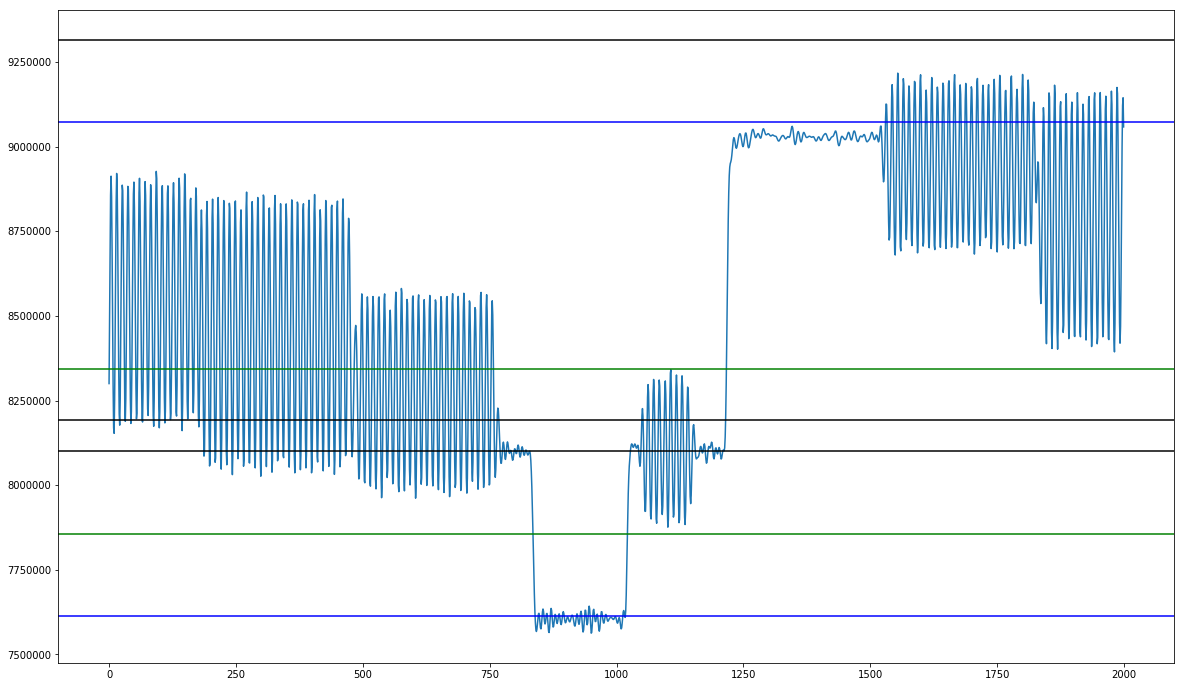

In [103]:
lineplot(tmp['demod'][15000:17000], filterset)
#plt.plot(tmp['demod_05'][1300:4000])
#plt.plot(tmp['demod_burst'][1300:4000] + 7500000)

In [104]:
calcsnr(tmp['demod'][3600:3800])

41.736185176315459

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

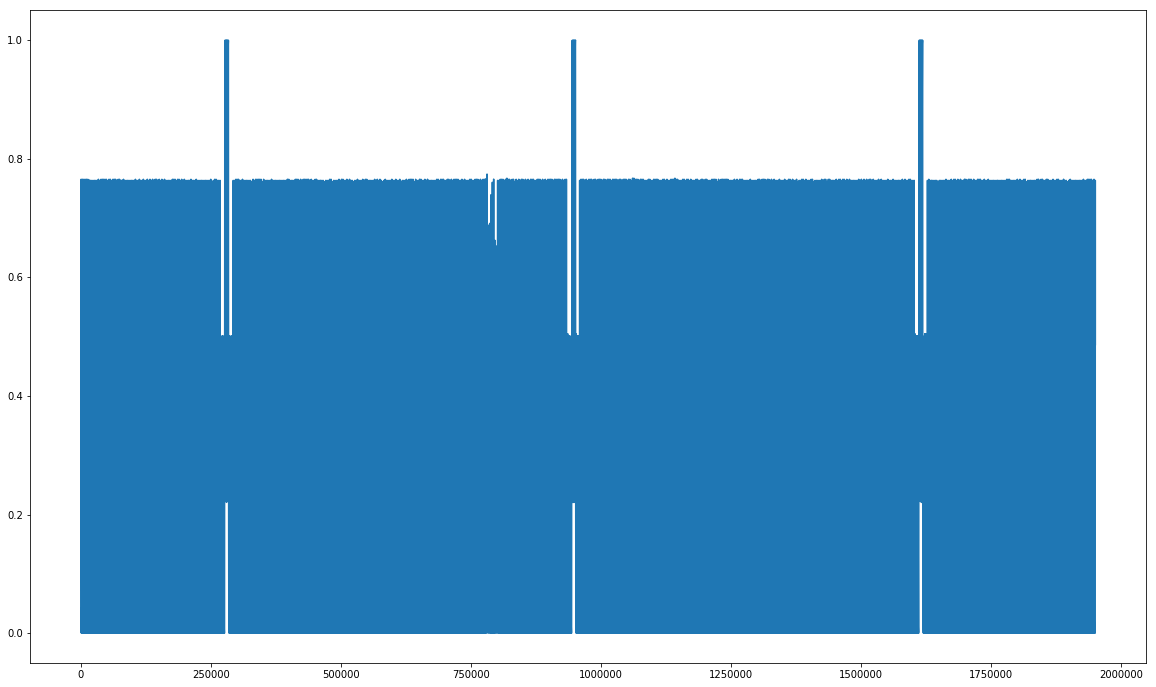

In [105]:
# This shows some nice patterns.  The glitches near the odd #'d syncs
plt.plot(tmp['demod_sync'])

In [106]:
output = tmp['demod']
output_sync = tmp['demod_sync']

In [107]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 0
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_sync):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_sync[loc:loc+imglen]) + loc

if np.max(output_sync[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")

syncloc

282513

In [108]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

prevline, nextline, pregap, postgap = findburstfromsync(output_sync, syncloc)

In [109]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [110]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
    print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]
    
#    if (i == 119):
#        break

295595 7774284.25917 8147405.917
298136 7788484.53708 8123351.2824
300677 7755944.82042 8117961.95203
303218 7768846.80865 8124420.8112
305759 7745005.74063 8126621.05704
308300 7773770.86371 8126507.06032
310841 7760679.69411 8130993.00451
313382 7766983.30495 8121055.06539
315923 7762706.73822 8104468.33112
318464 7782799.36295 8125410.38088
321005 7743894.1895 8119358.2244
323546 7785573.00463 8140618.41991
326087 7763879.26994 8121908.43153
328627 7743143.51659 8132758.2498
331169 7765397.69547 8116865.62916
333709 7740281.93534 8133021.74602
336251 7783607.40597 8110881.14886
338792 7778219.29815 8117595.20446
341333 7773795.12397 8114613.74015
343874 7792156.99191 8137391.36718
346415 7783719.0794 8120661.46426
348955 7742130.73323 8126494.86283
351497 7781505.93423 8097988.25051
354037 7739565.68202 8125940.16527
356578 7771055.23103 8131938.24515
359119 7738865.46542 8127997.85607
361660 7764389.29663 8116156.91804
364201 7743966.38212 8125516.75671
366743 7794853.48992 8118639

In [111]:
def iretohz(ire):
    return 8100000+(hz_ire_scale*ire)

In [112]:
m20ire = 8100000-hz_ire_scale*20

In [113]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [114]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


295595 7774284.25917 7822035.39053 7882005.8566
298136 7788484.53708 7862898.75045 7934061.4322
300677 7755944.82042 7843012.02493 7936275.24867
303218 7768846.80865 7837916.68503 7912805.70049
305759 7745005.74063 7834581.60071 7928850.02506
308300 7773770.86371 7842868.22256 7916351.97161
310841 7760679.69411 7812401.31052 7879951.01758
313382 7766983.30495 7834717.1021 7910375.08002
315923 7762706.73822 7823687.59107 7900471.9736
318464 7782799.36295 7846232.9831 7915386.68153
321005 7743894.1895 7822725.94641 7914004.39105
323546 7785573.00463 7848658.88815 7917859.98599
326087 7763879.26994 7844978.59341 7930765.82913
328627 7743143.51659 7800959.31506 7866359.89035
331169 7765397.69547 7832504.35598 7914265.86641
333709 7740281.93534 7799472.15027 7864172.89911
336251 7783607.40597 7845798.75631 7921539.60626
338792 7778219.29815 7853643.60743 7935612.3251
341333 7773795.12397 7836449.05616 7912373.97647
343874 7792156.99191 7862906.50488 7936113.03254
346415 7783719.0794 7872177

In [115]:
lineinfo2e = []

c = 0
for l in lineinfo:
    zc = calczc(output, int(l - 10 + (filterset['line_px'] * 55 / 63.5)), m20ire, 200)
    
    if zc is None:
        lineinfo2e.append(l)
        continue
        
    lineinfo2e.append(zc)
    print(l, lineinfo2[c], lineinfo2e[c], output[l], output[l + 1], output[l + 2])
    c += 1
    


295595 292973 292973 7774284.25917 7822035.39053 7882005.8566
298136 295596.633055 297951.068716 7788484.53708 7862898.75045 7934061.4322
300677 298136.961046 300492.155199 7755944.82042 7843012.02493 7936275.24867
303218 300678.182151 303033.048938 7768846.80865 7837916.68503 7912805.70049
305759 303219.294881 305574.28411 7745005.74063 7834581.60071 7928850.02506
308300 305760.269639 308115.271704 7773770.86371 7842868.22256 7916351.97161
310841 308301.233137 310656.127419 7760679.69411 7812401.31052 7879951.01758
313382 310842.704647 313197.057662 7766983.30495 7834717.1021 7910375.08002
315923 313383.334174 315738.239838 7762706.73822 7823687.59107 7900471.9736
318464 315924.472914 318279.329186 7782799.36295 7846232.9831 7915386.68153
321005 318465.199079 320820.210274 7743894.1895 7822725.94641 7914004.39105
323546 321006.408355 323361.434232 7785573.00463 7848658.88815 7917859.98599
326087 323547.163886 325902.1165 7763879.26994 7844978.59341 7930765.82913
328627 326088.175101 3

In [116]:
# experiment:  filter color burst data for easier alignment

In [117]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


295595 7774284.25917 7822035.39053 7882005.8566
298136 7788484.53708 7862898.75045 7934061.4322
300677 7755944.82042 7843012.02493 7936275.24867
303218 7768846.80865 7837916.68503 7912805.70049
305759 7745005.74063 7834581.60071 7928850.02506
308300 7773770.86371 7842868.22256 7916351.97161
310841 7760679.69411 7812401.31052 7879951.01758
313382 7766983.30495 7834717.1021 7910375.08002
315923 7762706.73822 7823687.59107 7900471.9736
318464 7782799.36295 7846232.9831 7915386.68153
321005 7743894.1895 7822725.94641 7914004.39105
323546 7785573.00463 7848658.88815 7917859.98599
326087 7763879.26994 7844978.59341 7930765.82913
328627 7743143.51659 7800959.31506 7866359.89035
331169 7765397.69547 7832504.35598 7914265.86641
333709 7740281.93534 7799472.15027 7864172.89911
336251 7783607.40597 7845798.75631 7921539.60626
338792 7778219.29815 7853643.60743 7935612.3251
341333 7773795.12397 7836449.05616 7912373.97647
343874 7792156.99191 7862906.50488 7936113.03254
346415 7783719.0794 7872177

In [118]:
# now to get fine sync!

In [119]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    

x = np.arange(0, 400)
scale(x, 50.5, 60.5, 10)

array([ 50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5])

In [120]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
#        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)
        scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
        sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

#lines, sfactor = downscale(output_cburst, lineinfo3)
    
#reduced = (lines - minn) / hz_ire_scale
#lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


In [121]:
#drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [122]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [123]:
def calcerr(subset):
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [156]:
lineinfo_tmp = lineinfo2.copy()
#lineinfo3 = [(lineinfo2[0], lineinfo[1])]
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
badburst = np.zeros_like(lineinfo_tmp)
finalsnr = []

for l in range(1, len(lineinfo2) - 1):
    # hsync check
    scaled = scale(output, lineinfo_tmp[l - 1], lineinfo_tmp[l], 910) 
    subset = scaled[850:910]
    if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
        badburst[l] = 1
    
    # color burst check
    #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    scaled = scale(output, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    subset = scaled[5:60]
    
    #print(l, np.min(subset), np.max(subset))
    if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
        badburst[l] = 1

for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        #scaled = scale(tmp['demod_burst'] + 8100000, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
        scaled = scale(output, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if not badburst[l]:
            offset1 = calcerr(scaled[5:60])
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * .5)
        else:
            offset1 = None
        if not badburst[l + 1]:
            offset2 = calcerr(scaled[915:970])
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * .5)
        else:
            offset2 = None

        print(l, i, lineinfo_tmp[l], offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
#    print(lineinfo_tmp[l + 1], lineinfo3[l][1])
    lineinfo_tmp[l + 1] = lineinfo3[l][1]

finalsnr = []    
    
for i in range(1, len(lineinfo2) - 1):
    if badburst[i] and not (badburst[i - 1] or badburst[i + 1]):
        print(i, lineinfo3[i - 1], lineinfo3[i], lineinfo3[i + 1])
        print((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)
        lineinfo3[i] = ((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2, lineinfo3[i][1])
        lineinfo3[i - 1] = (lineinfo3[i - 1][0], (lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)

    linelen = lineinfo3[i][1] - lineinfo3[i][0]
    line12end = lineinfo3[i][0] + (linelen * 1.2)
        
    scaled = scale(output, lineinfo3[i][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(i, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 0 295596.630035 -0.00216385747372 0.0526104662853 33.2088480977
1 1 295596.627301 -0.0019584484012 0.0310997178509 34.1367517814
1 2 295596.62512 -0.00156293463096 0.0410159619701 34.7406029809
1 3 295596.623091 -0.00145301260435 0.0321113414883 35.5718409607
1 4 295596.621312 -0.00127445303587 0.0263433846044 36.2719574509
1 f 0.0354091793796 0.0337298182376 36.8784285735
2 0 298137.234034 0.0123887340772 -0.00854064511842 41.7002244802
2 1 298137.244871 0.00776218098524 -0.00493125506946 41.4124217563
2 2 298137.25165 0.00485564414868 -0.00283959403295 41.2005076366
2 3 298137.255884 0.00303331172321 -0.00163026952646 41.060516619
2 4 298137.258527 0.0018926693465 -0.000932879969278 40.9719394429
2 f 0.0194404630837 0.00155721891844 40.9170092714
3 0 300678.152039 -0.0026936512265 -0.00682950433803 39.9223135427
3 1 300678.149824 -0.00158611300845 -0.00409817493706 39.9629574443
3 2 300678.148521 -0.000932979936695 -0.00245939741349 39.9865120851
3 3 300678.147756 -0.00054817861958

34 3 379448.616796 -0.000243439998758 0.0597939089573 38.7928859397
34 4 379448.615551 -0.000891704163824 0.0353969402813 40.2459268571
34 f 0.033930536592 0.0501365347539 41.0294771416
35 0 381989.665396 0.0501586584462 0.06921327194 41.6130256229
35 1 381989.707671 0.0302801900206 0.0418294403665 41.7957050159
35 2 381989.747872 0.0287944827488 0.0253395585547 41.8639719701
35 3 381989.772351 0.0175336119151 0.0154816733588 41.8487042856
35 4 381989.787244 0.0106673596426 0.00945460552816 41.8381139013
35 f 0.0248151454801 0.022756129874 41.8313303599
36 0 384530.752084 0.00925689575741 0.00469861404051 35.0664182687
36 1 384530.760029 0.00569155896432 0.00279540571573 34.9808318048
36 2 384530.764914 0.0034995684868 0.0426223989474 34.9267633815
36 3 384530.780975 0.0115051550482 0.0244790594934 35.6807793575
36 4 384530.790501 0.00682412979694 0.0518367957225 35.9409910919
36 f 0.0106108421114 0.0811408346246 36.8781128458
37 0 387071.573798 0.0716991820454 -0.000670769016182 38.02

68 2 465846.388797 0.00505466475757 -0.0502365912052 28.2392180472
68 3 465846.394014 0.00373890600933 -0.0148002864347 27.7425945939
68 4 465846.397496 0.00249489892758 -0.00414499893642 27.5828652822
68 f 0.0063586757983 0.104056643123 27.5264656731
69 0 468386.094905 -0.0437288123247 -0.0295664943618 27.2374178868
69 1 468386.075373 -0.0139816410736 -0.0181009623783 27.1211806772
69 2 468386.069517 -0.00419222699438 -0.0109301258791 27.1544265036
69 3 468386.067937 -0.00113071326246 -0.00654827201918 27.2093930283
69 4 468386.067626 -0.000222759725587 -0.00390588175095 27.2539083947
69 f 0.107101599699 0.0140037811707 27.2843276791
70 0 470928.507688 0.00948484098044 0.0188242537623 43.0142367676
70 1 470928.515552 0.00563251868282 0.0112670488074 43.0259941195
70 2 470928.520222 0.00334486860364 0.01748738822 43.0171540537
70 3 470928.522813 0.00185536475274 0.0104171577089 42.9432385968
70 4 470928.524238 0.00102055800202 0.00620517144425 42.8636433143
70 f 0.0165983151173 0.03687

100 0 547167.882154 -0.00800036084665 0.223823491553 33.2854292429
100 1 547167.87138 -0.00771230877827 0.206135367238 30.1580460072
100 2 547167.86116 -0.00731544192883 0.0769019103162 27.9932555624
100 3 547167.853519 -0.00546971022224 0.0208505149943 27.2750167238
100 4 547167.848439 -0.00363594174382 0.00527449604162 27.0632614856
100 f 0.037106751705 -0.00412133480783 26.9928284658
101 0 549710.696288 0.0441377591879 0.00991294023803 26.9899090247
101 1 549710.715165 0.0135264042547 0.00640252784347 26.7309569599
101 2 549710.720776 0.0040202122461 0.00395257370151 26.6782982655
101 3 549710.722386 0.00115369156509 0.00238745470554 26.6779323764
101 4 549710.72281 0.000303707088761 0.00142661862755 26.6871440685
101 f -0.00630896022255 0.0374398232355 26.6955123567
102 0 552250.715426 -0.0150162528574 0.00128945171549 36.2733639743
102 1 552250.702468 -0.00927835000564 0.000545004951837 35.9643249221
102 2 552250.694466 -0.00572979084439 0.000191493626365 35.7801646548
102 3 55225

135 2 636125.153052 -0.000424366729779 0.00459480358869 39.2936567194
135 3 636125.152607 -0.000319013598418 0.00271900960984 39.2121249577
135 4 636125.152285 -0.000230658984806 0.0122600279491 39.1616381082
135 f 0.0251894096339 0.0121492765355 38.9460890636
136 0 638667.279643 0.00232552877723 0.0875297088997 34.1734572832
136 1 638667.280119 0.000341443802769 0.0673836947708 35.7431502016
136 2 638667.294026 0.00995786023561 0.0590034378052 37.0767476086
136 3 638667.301593 0.00541852319306 0.0448588925812 38.0627139734
136 4 638667.305489 0.00278952358783 0.0265449651193 38.812470812
136 f 0.00618280622142 0.0384082026159 39.22071274
137 0 641209.182944 0.0157426508619 0.0123878657775 41.6282320716
137 1 641209.196289 0.00955546114541 0.00752231041313 41.5997894891
137 2 641209.204391 0.00580097590428 0.00456941279204 41.581225247
137 3 641209.209309 0.00352181347014 0.0027761439132 41.5695003606
137 4 641209.212295 0.00213810258506 0.00168677423352 41.5622270855
137 f 0.024015952

166 4 714929.896745 -0.00219057133761 0.0340865441641 42.3059038903
166 f 0.0147097469657 0.0220142014671 42.7713298786
167 0 717472.384411 0.0159808671979 -0.0163323921615 38.4739902447
167 1 717472.398535 0.0101088267575 -0.00935337257193 39.2551666837
167 2 717472.407451 0.00638151526168 -0.00535831709762 39.7275687314
167 3 717472.413069 0.00402116989051 -0.00306653588047 40.0100282184
167 4 717472.416604 0.00252968646088 -0.00175171328733 40.1787318975
167 f 0.0249597247486 -0.00964307622401 40.2797397196
168 0 720015.240645 -0.000154035250154 -0.017606364966 39.3462092539
168 1 720015.240819 0.000124806372698 -0.0101952693074 39.5765769277
168 2 720015.241103 0.000203452806357 -0.0264405704742 39.6965466894
168 3 720015.241737 0.000453915482532 -0.0345055417201 39.9411149995
168 4 720015.242726 0.000707846878075 -0.0349144460561 40.0973988987
168 f -0.00784826160418 -0.00532141820661 40.0459180728
169 0 722557.771238 -0.0189168228339 0.0329456493599 39.2372389272
169 1 722557.754

202 f 0.0194453454125 0.0134804930105 32.8076248877
203 0 809009.956746 0.00589631827442 -0.0419265720374 37.2031668765
203 1 809009.962575 0.00417175000507 -0.0245428021909 37.9081020045
203 2 809009.966608 0.00288707629355 -0.0144264318901 38.223437714
203 3 809009.969355 0.00196576446752 -0.00849382927296 38.362132895
203 4 809009.971201 0.00132170748202 -0.00500340317191 38.4248652286
203 f 0.0234851898991 0.0105014741294 38.45470186
204 0 811552.724337 -0.00168240558241 -0.0271283515375 37.5482761961
204 1 811552.723353 -0.00070400769292 -0.016102932159 37.6228315276
204 2 811552.723024 -0.000236104299423 -0.00957266849139 37.6307487495
204 3 811552.722985 -2.77651754352e-05 -0.00569350627307 37.6217270253
204 4 811552.723059 5.3040351392e-05 -0.00338647675879 37.6111869737
204 f 0.013480442754 0.0128668255382 37.6029341298
205 0 814095.248826 -0.00260756369031 0.0120089953011 39.0930381733
205 1 814095.24636 -0.00176529796833 0.00708018640251 39.3183709536
205 2 814095.244708 -0.

239 f 0.0248156360726 0.0308495055326 41.2805255909
240 0 903098.19801 0.00784840039067 0.0503690240975 39.6855850658
240 1 903098.203901 0.00421608235616 0.0297624826032 40.4957152636
240 2 903098.207019 0.00223154366078 0.0176435628381 40.8880343142
240 3 903098.208636 0.00115774512748 0.0449362641897 41.0761288072
240 4 903098.208856 0.000156956995391 0.0265872520768 41.3579663293
240 f 0.0236460344159 0.0340265688929 41.3255388088
241 0 905641.300562 0.0208067054593 0.0612128576616 36.0318246268
241 1 905641.317408 0.0120585737643 0.0522830318414 36.8556197259
241 2 905641.326871 0.00677387462368 0.0306090531568 37.7109412941
241 3 905641.332163 0.00378820999422 0.0180449753657 38.2279575361
241 4 905641.335106 0.00210627356489 0.0106714182007 38.5379109992
241 f 0.0374431395285 0.0479443518067 38.7235043524
242 0 908184.037627 0.0167328495803 0.00478477898694 40.7195673641
242 1 908184.051961 0.0102581138719 0.00303781611084 40.8938791214
242 2 908184.060755 0.00629361231995 0.001

106 f 0.0210493177307 -0.00308422926946 26.8454242428
107 f -0.00611983215739 0.0201308350039 27.535993916
108 f 0.0234040158452 0.0466638844674 41.2779274371
109 f 0.0416483944657 0.0217064718673 38.9462909042
110 f 0.0212848177214 0.0222614939748 39.3965568962
111 f 0.0218866402388 0.0197660132737 40.4756340562
112 f 0.0166226620151 0.0352720532432 40.789451268
113 f 0.0204942759672 0.0125158870187 39.972752482
114 f 0.0154072207172 0.00114962829918 36.7212435235
115 f 0.0185257190226 0.023675013781 37.1185334065
116 f 0.0234132130397 0.0218349295939 41.3949134594
117 f 0.0222733134143 0.0305581738767 43.1301585393
118 f 0.0230262848344 0.00650036588491 41.7975122458
119 f 0.0120718525777 0.020605287913 39.842445545
120 f 0.0209366326722 0.0137714256981 40.089519213
121 f 0.0313715480308 0.0281803045133 40.174637923
122 f 0.0259459134661 0.0381916104896 40.3760911141
123 f 0.0476618559689 0.00577486737758 40.4089255256
124 f 0.00242895686415 0.0270199202256 39.2253525886
125 f 0.0242

In [157]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr) + 1

(37.584981063870003, 15.02219625443276, 197)

In [148]:
for i in range(len(lineinfo3) - 1):
    print(i, lineinfo3[i + 1][0] - lineinfo3[i][1], lineinfo3[i])

0 1.62131228234 (292973, 295595)
1 0.041789449635 (295596.62131228234, 298137.21673737845)
2 -0.008492723573 (298137.25852682808, 300678.15579953487)
3 0.00370189372916 (300678.1473068113, 303219.27289196028)
4 -0.0176049178117 (303219.27659385401, 305760.18274941563)
5 -0.00790095835691 (305760.16514449782, 308301.34179191623)
6 0.150959674094 (308301.33389095787, 310843.54315601714)
7 -0.0377683069673 (310843.69411569124, 313383.363624555)
8 0.00359151052544 (313383.32585624803, 315924.40195804124)
9 -0.0180315621546 (315924.40554955177, 318465.15604687098)
10 0.0199460021104 (318465.13801530882, 321006.42143149261)
11 -0.0253619448631 (321006.44137749472, 323547.04758243181)
12 -5.27664669789e-05 (323547.02222048695, 326088.10444892832)
13 0.00157640490215 (326088.10439616186, 328629.02893772285)
14 -0.108730012726 (328629.03051412775, 331170.15622146073)
15 0.00143006502185 (331170.047491448, 333711.02656478056)
16 0.00373907265021 (333711.02799484559, 336252.16777197993)
17 0.0048

37.5849810639
(230230,)
uint8 (253, 910) (253, 910)


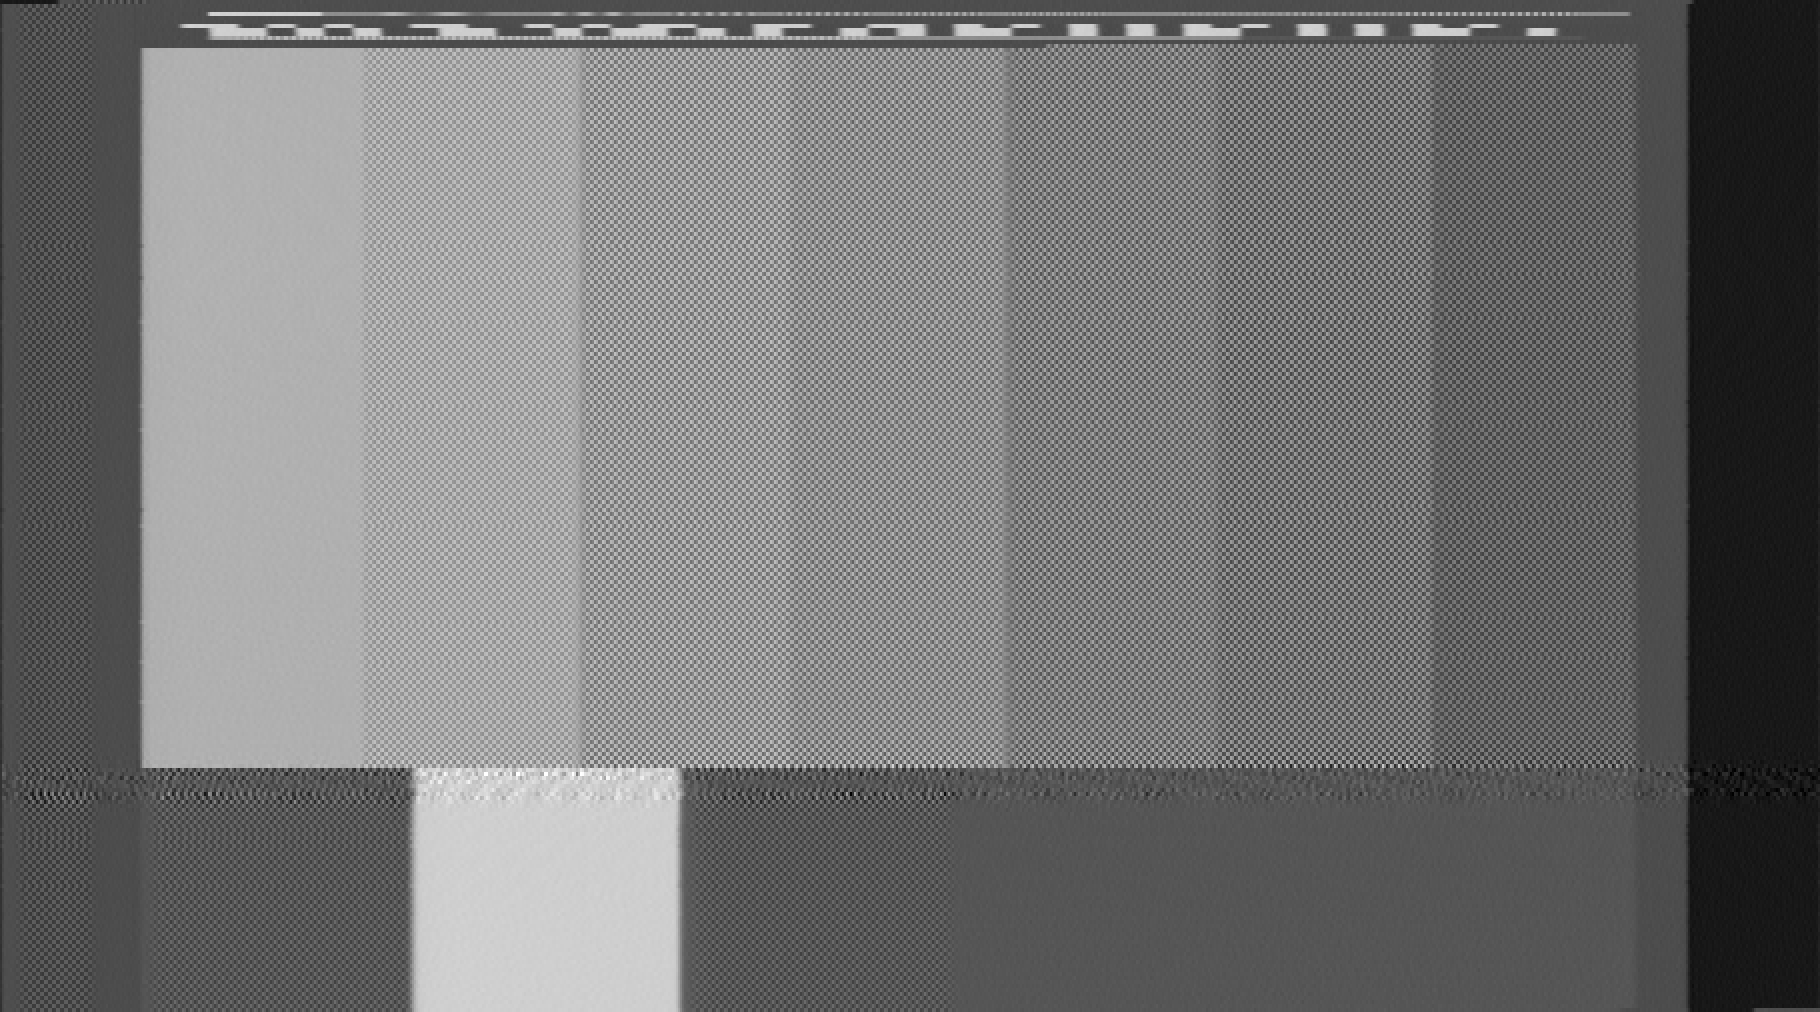

In [149]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [170]:
lineinfo3

[(1153165, 1155043),
 (1155045.1003165401, 1156864.4318928756),
 (1156864.4065342685, 1158685.1869836131),
 (1158685.8767081511, 1160506.2982147641),
 (1160506.3070537609, 1162326.6455798117),
 (1162326.671701161, 1164146.2113689831),
 (1164146.1882466027, 1165967.4730567266),
 (1165967.5042828643, 1167787.8940333868),
 (1167787.9000075657, 1169608.2939069264),
 (1169608.2953764619, 1171428.7788133163),
 (1171428.8107410334, 1173248.2846293068),
 (1173248.2385064852, 1175069.4805959095),
 (1175069.6150243476, 1176889.8890084911),
 (1176889.8880245027, 1178710.3220185868),
 (1178710.3314516903, 1180530.6907912048),
 (1180530.6975253464, 1182351.1280369351),
 (1182351.1809651828, 1184171.4662705574),
 (1184171.471533729, 1185991.8983398974),
 (1185991.9291059007, 1187812.2180585645),
 (1187812.2738351498, 1189632.6935383347),
 (1189632.7392507542, 1191452.7965770999),
 (1191453.1481934406, 1193273.5515724553),
 (1193273.5594163265, 1195093.8885963634),
 (1195093.9201923108, 1196913.83137

In [171]:
lineinfo[3], lineinfo[4]

(1158684, 1160504)

/home/cpage/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cpage/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cpage/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(14.373313635841217, nan)

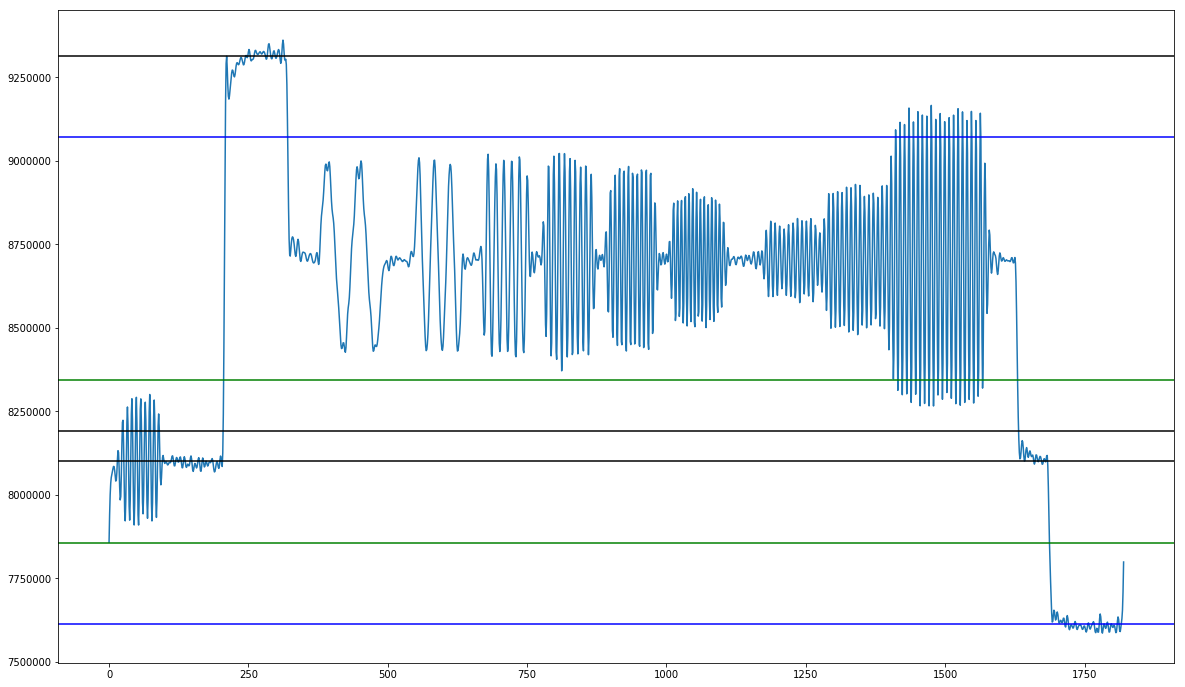

In [172]:
l = 3
x = output[int(lineinfo3[l][0]):int(lineinfo3[l+1][0])]
lineplot(x, filterset)
calcsnr(x[300:400]), calcsnr(x[2400:2530])

(17.351692098026351, 35.329880793360346)

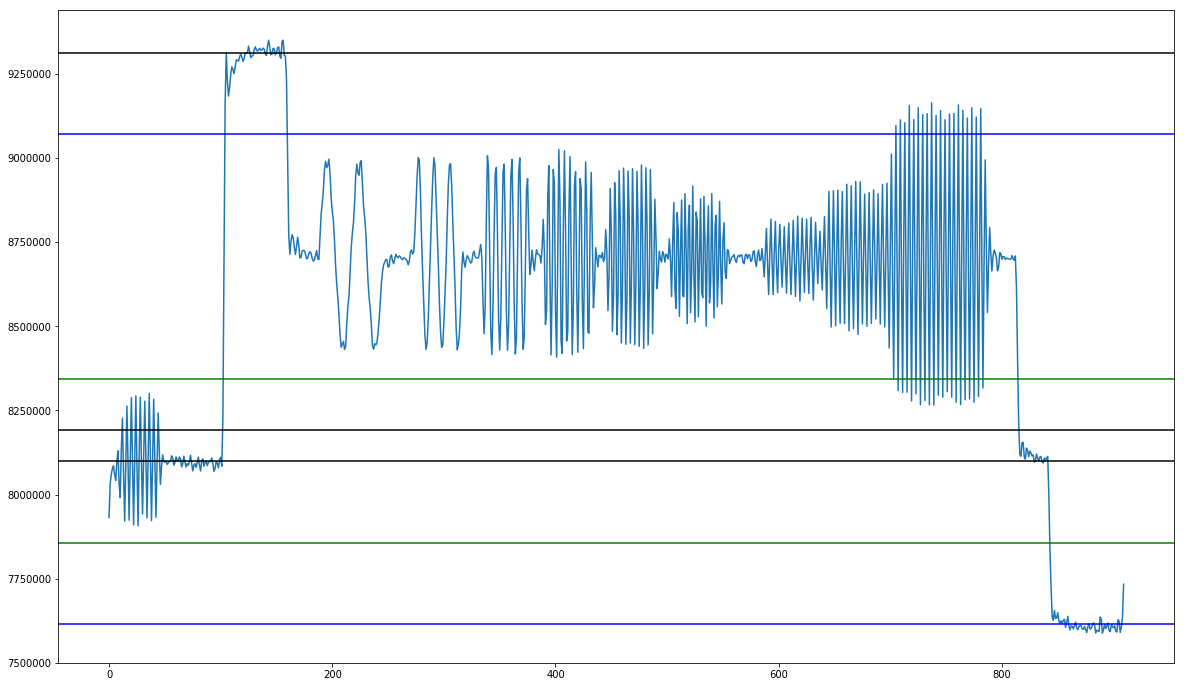

In [173]:
l = 3
x = lines[l * 910:(l + 1) * 910]
lineplot(x, filterset)
calcsnr(x[300:400]), calcsnr(x[850:])

In [695]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 -0.154741137918 845.368979898 909.861959977 37.4950262196
3 -0.138040022963 845.484546213 909.9074071 39.53515591
4 -0.0925929003539 845.450885029 909.909596074 38.2483850861
5 -0.0904039259235 845.431623837 909.909069945 38.7810154812
6 -0.090930054506 845.442284106 909.86090586 38.7791257511
7 -0.139094139965 845.425737295 909.832417702 39.7752201802
8 -0.167582298308 845.27221555 909.925389741 38.3505643762
9 -0.0746102585259 845.027630874 909.812592829 34.1564994399
10 -0.187407171451 845.224789305 909.883270826 38.0456201704
11 -0.116729174283 845.393663928 909.831584864 37.2948848883
12 -0.168415135823 845.195340354 909.928115571 36.7303025515
13 -0.0718844287775 845.338972519 909.837234703 36.2558223715
14 -0.162765296637 845.386983961 909.95733255 36.5790130216
15 -0.0426674502844 845.357508123 909.888763879 40.4586957605
16 -0.111236121343 845.278593138 909.928385346 37.6993434262
17 -0.0716146538122 845.114413832 909.880244413 38.2993437394
18 -0.119755586585 845.315334887 

In [696]:
np.mean(zclen), np.std(zclen)

(64.535136767752377, 0.11737262082938797)

In [697]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.062264975967787954, 0.10891155743135103, 38.206862345726094)

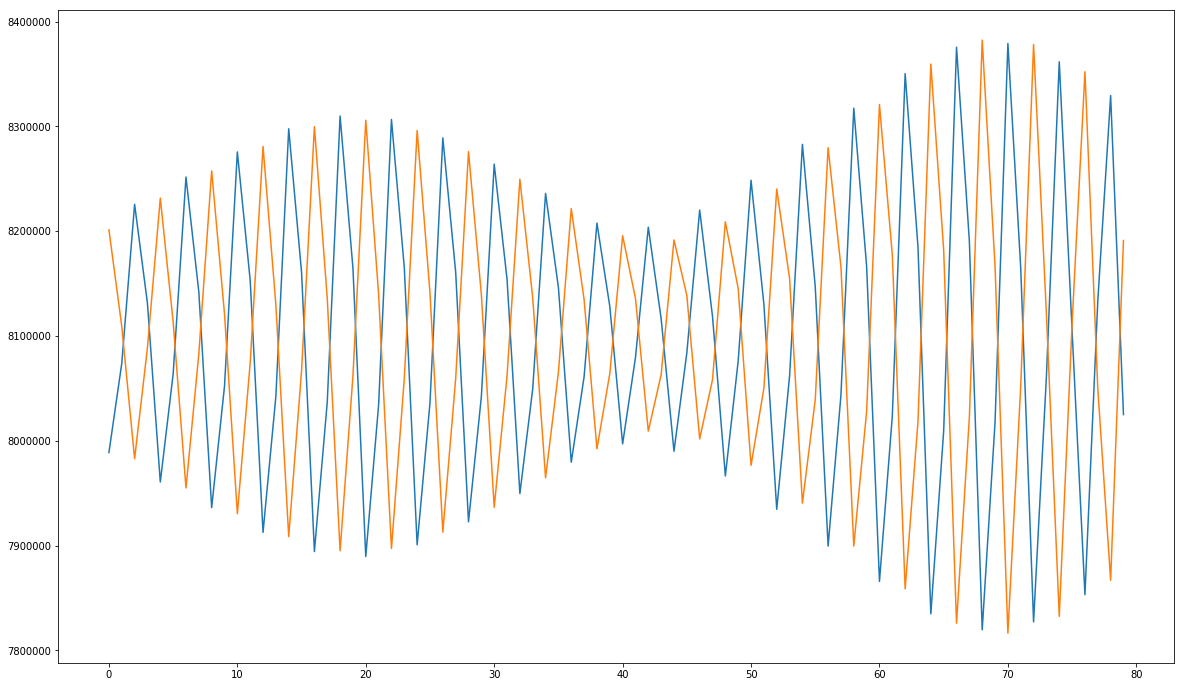

In [913]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)
l = l + 1
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)


In [770]:
lineinfo_cur[100], lineinfo_cur[101]

(1160549.1033076106, 1163347.4488508701)

43.451705388955098

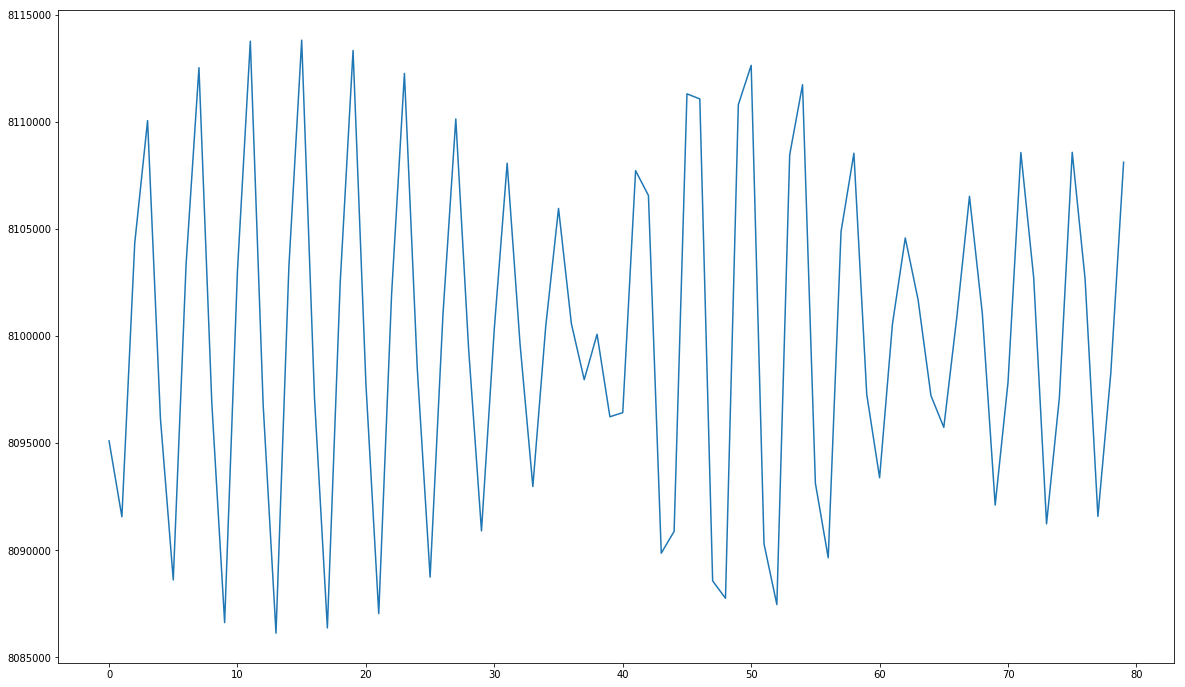

In [914]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
#plt.plot(x)
l = l + 1
y = (x + lines[(910*l)+0:(910*l)+80]) / 2
plt.plot(y)
calcsnr(y[15:50])


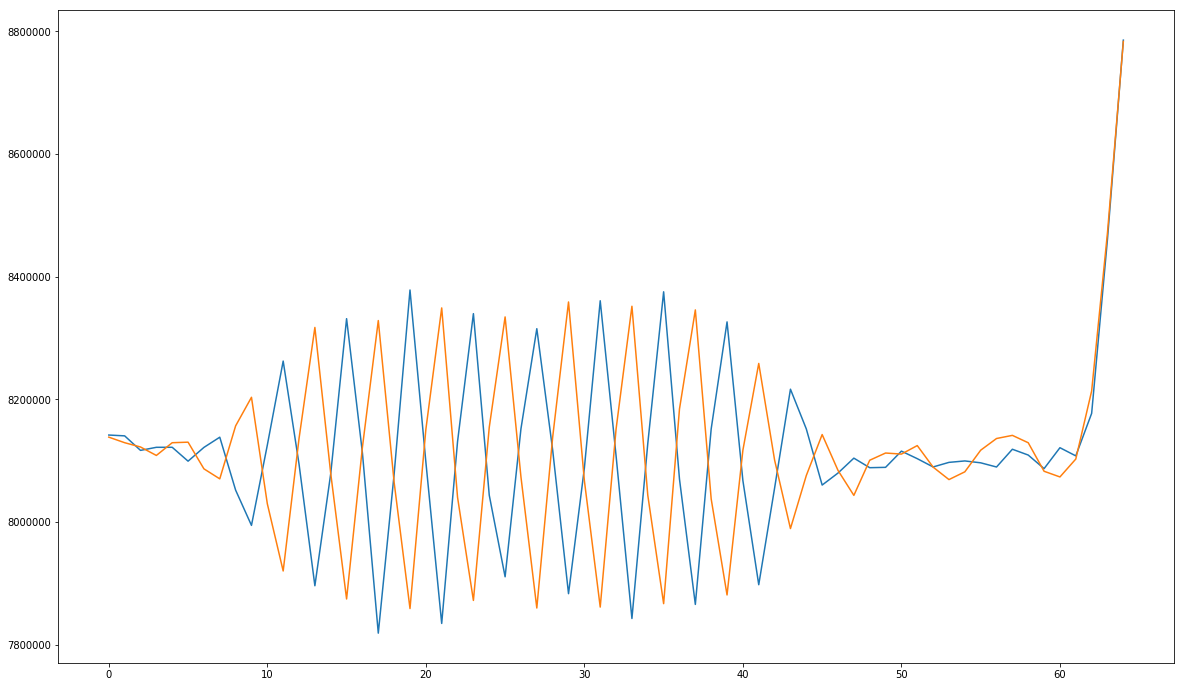

In [137]:
l = 50
x = lines[(910*l)+5:(910*l)+70]
plt.plot(x)
y = lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(y)

22.0131165809


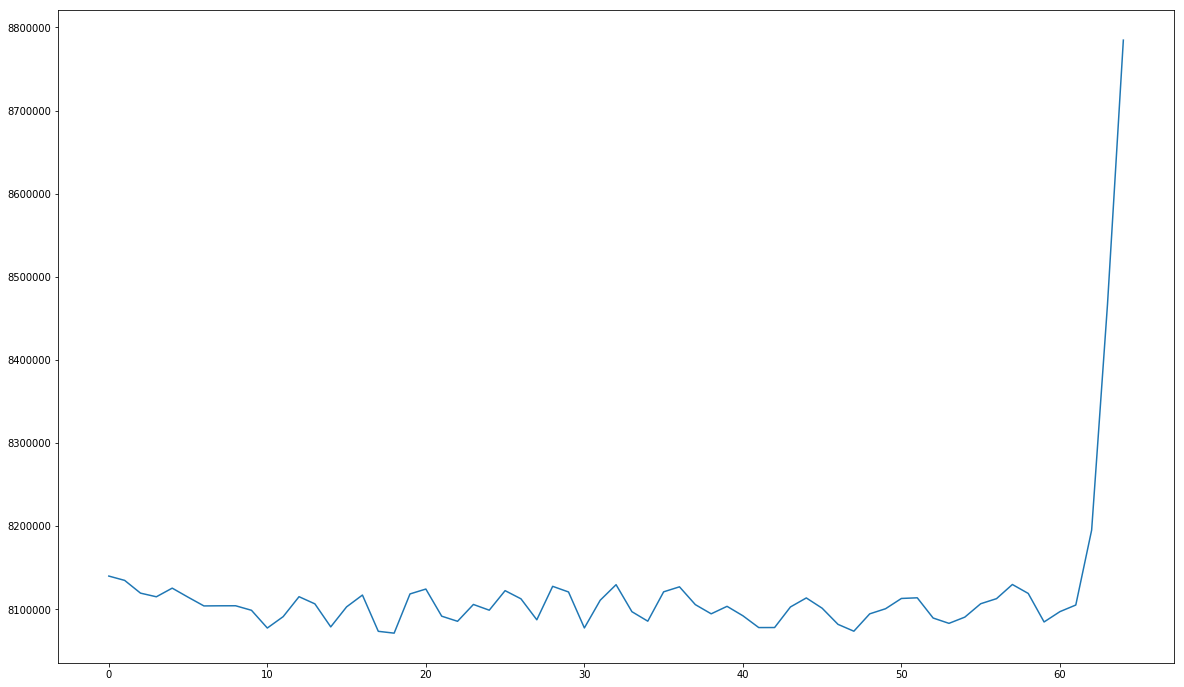

In [138]:
l = 50
x = lines[(910*l)+5:(910*l)+70] + lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(x / 2)
calcsnr(x / 2)

(230230,)
uint8 (253, 910) (253, 910)


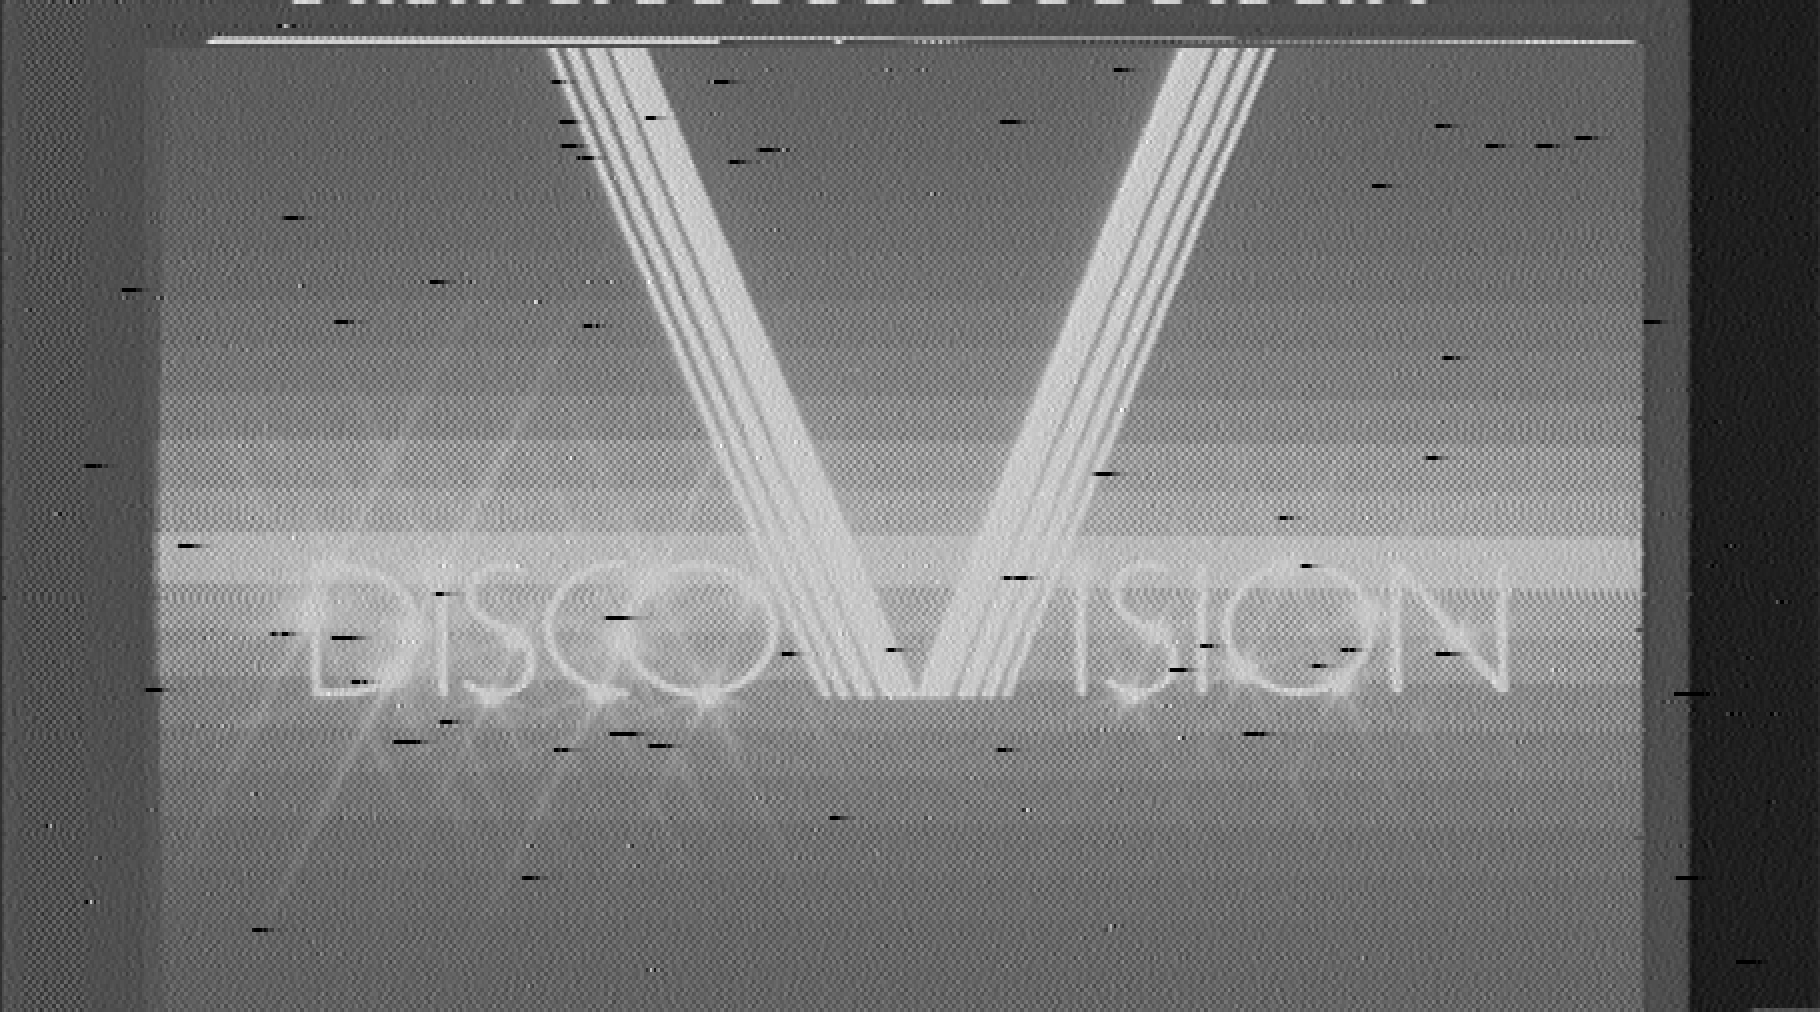

In [35]:
# Example of this code on a rotter :)
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [36]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

In [37]:
910/63.5, 58.5*(910/63.5)

(14.330708661417322, 838.3464566929133)

In [38]:
begline = []
endline = []
for l in range(0, len(lineinfo_cur) - 1):
    cline = lines[l * 910:(l + 1) * 910]
    begline.append(calczc(cline, 0, 8000000, 5))
    endline.append(calczc(cline, 840, m20ire, 20))
    if (begline[-1] is None):
        print("b", l)
        begline[-1] = -1
    if (endline[-1] is None):
        print("e", l)
        endline[-1] = 844.25

e 173
e 219


In [39]:
np.min(begline), np.max(begline), np.mean(begline), np.argmax(begline), np.std(begline)

(0.36511998949632013,
 2.7357543924367347,
 0.76349998963594301,
 149,
 0.25001621551811237)

In [40]:
np.min(endline), np.max(endline), np.mean(endline), np.argmax(endline), np.std(endline)

(840.20959013105346,
 845.70162781330214,
 844.23547566598813,
 148,
 0.44573642405298891)

In [41]:
linegaps2 = np.diff(lineinfo2)
linegaps_end = np.diff(lineinfo_cur)

In [42]:
np.mean(linegaps2), np.std(linegaps2), np.min(linegaps2), np.max(linegaps2)

(2794.1198310133477,
 2.2242912880402335,
 2786.4846006617881,
 2799.5613464718917)

In [43]:
np.mean(linegaps_end), np.std(linegaps_end), np.min(linegaps_end), np.max(linegaps_end)

(2794.1198310133477,
 2.2716834575987628,
 2786.4032574766316,
 2800.2662368090241)

In [44]:
filterset['line_px']

2794.0

In [45]:
lineinfo2[147] - lineinfo2[146], lineinfo_cur[147] - lineinfo_cur[146]

(2792.3583034544718, 2792.7066011009738)

In [46]:
lineinfo2[120] - lineinfo2[119], lineinfo_cur[120] - lineinfo_cur[119]

(2791.6145233304705, 2792.2245435791556)

In [47]:
endline[147]

844.04832559894965

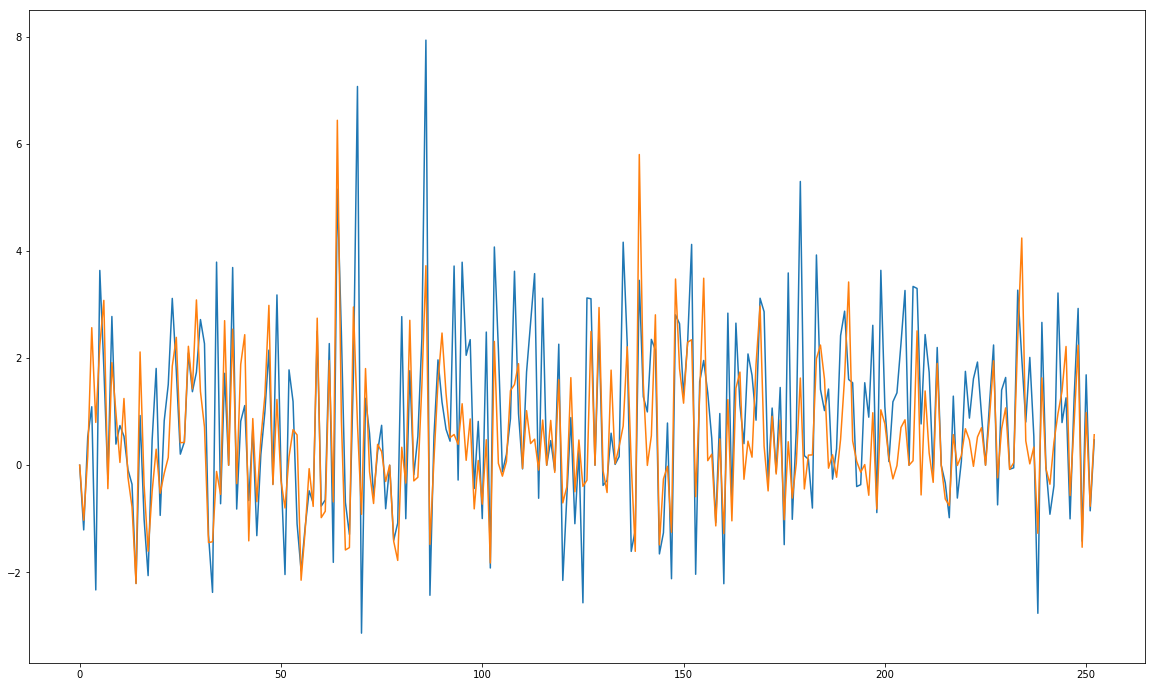

In [48]:
plt.plot(errs[0])
plt.plot(errs[-1])

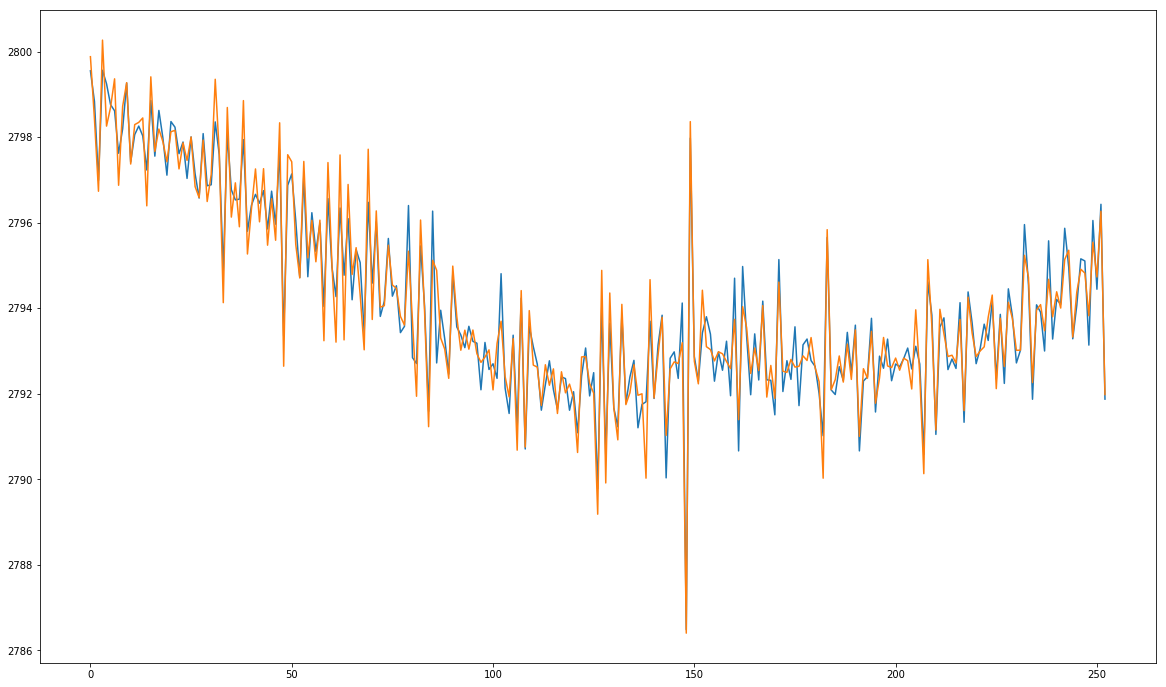

In [49]:
plt.plot(np.diff(lineinfo2))
plt.plot(np.diff(lineinfo_cur))

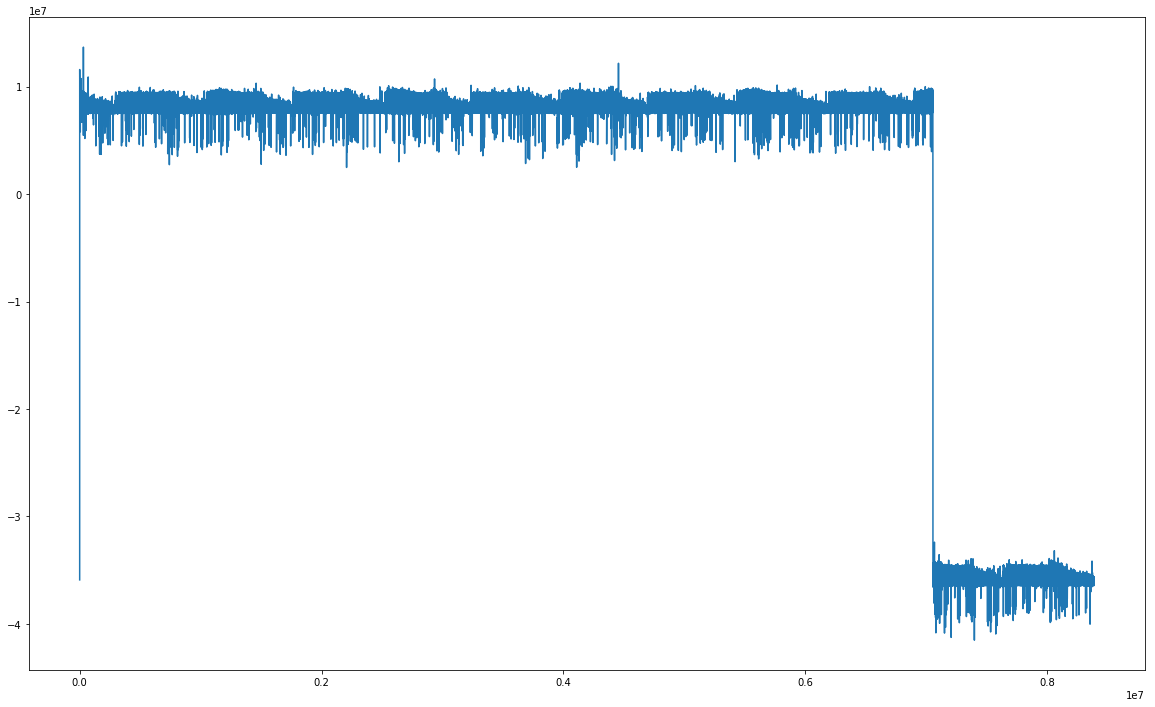

In [155]:
plt.plot(output)

In [22]:
len(output)

4194304

In [133]:
len(ocut)

4000000

In [136]:
cutlen = int(4000000 * (8 * 315/88 / 40))

In [137]:
o286_fft = np.fft.fft(ocut)

In [147]:

range(int(cutlen / 2), int(len(o286_fft) - (cutlen / 2)))

range(1431818, 2568182)

In [148]:
o286_fft_cut = np.delete(o286_fft, range(int(cutlen / 2), int(len(o286_fft) - (cutlen / 2))))

In [ ]:
output286 = np.fft.ifft(o286_fft_cut)

In [152]:
outfile = open('disco28.raw', 'wb')
outfile.write(output286)

45818176

In [82]:
output286 = scale(output, 94304, 8094304, 8000000 * (8 * 315/88) / 40)

/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


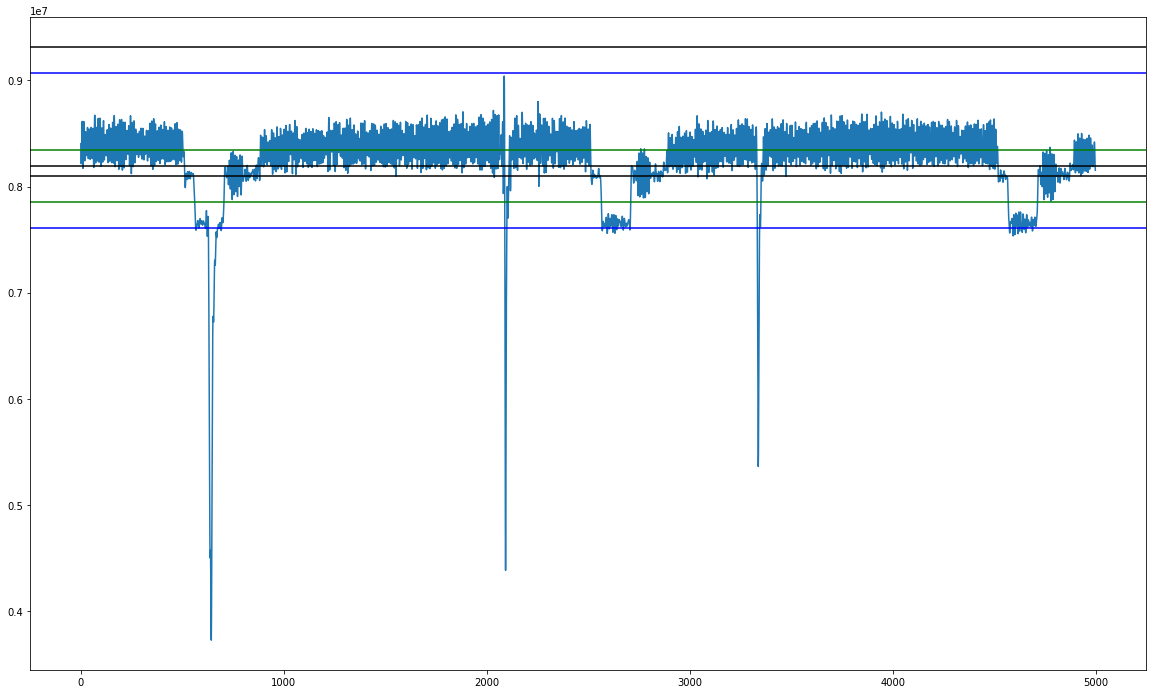

In [83]:
lineplot(output286[50000:55000], filterset)

In [119]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [120]:
reduced = (output286 - minn) / hz_ire_scale
output16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


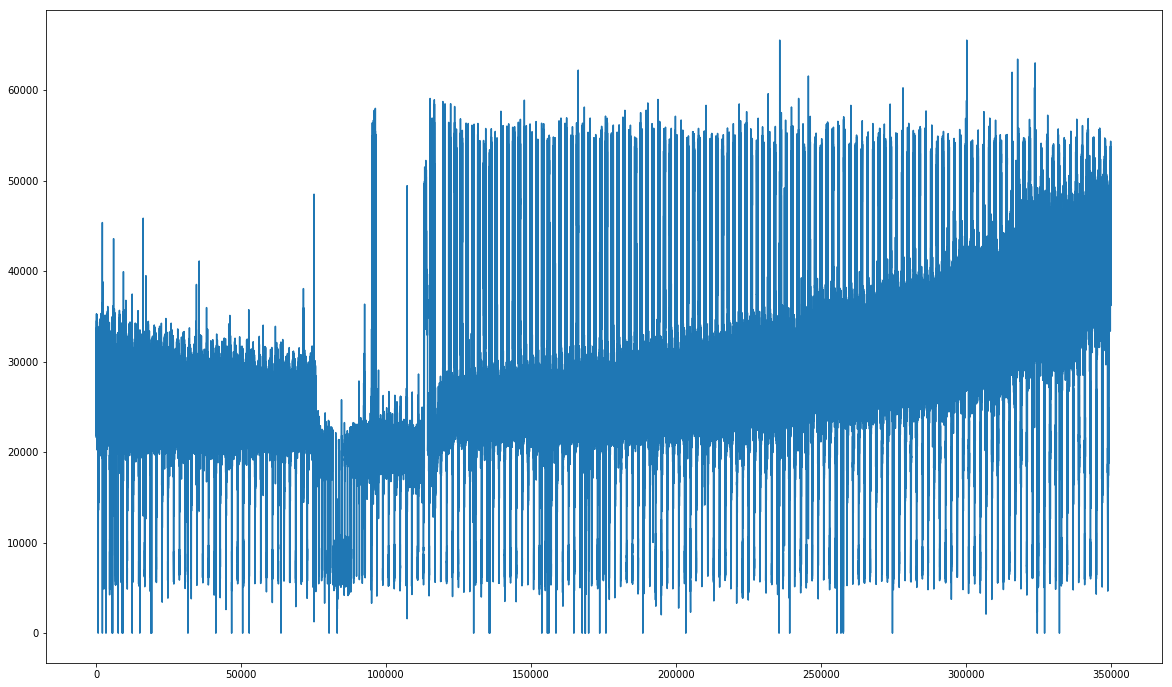

In [131]:
plt.plot(output16[50000:400000])

In [121]:
outfile = open('disco.ld', 'wb')
outfile.write(output16)

11454544

In [123]:
np.min(output16)

0

In [88]:
len(indata1)

16777216

In [92]:
cutlen = 64 * 1024

In [93]:
indata28 = scale(indata1, cutlen, len(indata1) - cutlen, (len(indata1) - (cutlen * 2)) * (8 * 315/88) / 40)


/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


In [116]:
indata28a = np.int16(np.clip(indata28, -32760, 32760))

In [117]:
np.min(indata28a)

-32760

In [118]:
outfile = open('disco28.raw', 'wb')
outfile.write(indata28a)

23834250

In [115]:
len(indata1)

16777216

In [96]:
(len(indata1) - (cutlen * 2)) * (8 * 315/88) / 40

11917125.818181818